In [1]:
import pandas as pd

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data, get_unique_genes
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# New Refactored Modules
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns

# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
# Load and preprocess the dataset
# This handles: Filtering Human, Dropping NaNs, Log Correction, and Pre-mRNA Mapping
all_data = preprocess_aso_data(UPDATED_CSV)

print(f"Data ready. Shape: {all_data.shape}")

Preprocessing complete. Final valid rows: 29987
Data ready. Shape: (29987, 29)


Preprocessing ASO Experimental Dataset

In [3]:
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.data.data import get_paths

target_genes = get_unique_genes(all_data)

paths = get_paths('GRCh38')
mapper = GeneCoordinateMapper(paths['db'])

# C. Fetch the raw genomic data
# This is the "heavy" part, but limited only to your experimental genes
gene_to_data = get_locus_to_data_dict(include_introns=False, gene_subset=target_genes)

# D. Build the Registry object
# This provides the {gene: {'cds_sequence': '...'}} mapping
ref_registry = build_gene_sequence_registry(
    genes=target_genes,
    gene_to_data=gene_to_data,
    mapper=mapper
)

print(f"Registry rebuilt for {len(ref_registry)} experimental genes.")

Elapsed DB:  0.0002894401550292969
Elapsed Fasta:  0.0002894401550292969
Length:  3267117988
Registry rebuilt for 15 experimental genes.


In [4]:
# Add structural features (e.g. secondary structure energy)
all_data = get_populated_df_with_structure_features(all_data, target_genes, gene_to_data)

In [5]:
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

# Run the optimized context generator
df_with_context = add_external_mrna_and_context_columns(
    df=all_data,
    mapper=mapper,
    gene_registry=ref_registry,
    flank_sizes_premrna=FLANK_SIZES_PREMRNA,
    flank_sizes_cds=CDS_WINDOWS
)

print("Genomic context added.")

Genomic context added.


In [7]:
from pandarallel import pandarallel
from tauso.features.seq_features import compute_ENC

# 1. Initialize pandarallel
pandarallel.initialize(progress_bar=True)

# 2. Parallelized Loop
for flank in CDS_WINDOWS:
    local_col = f"local_coding_region_around_ASO_{flank}"
    enc_col = f"ENC_score_{flank}_CDS"

    # Swap .apply with .parallel_apply
    df_with_context[enc_col] = df_with_context[local_col].parallel_apply(compute_ENC)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
import numpy as np

# 1. Pre-calculate ENC scores for the unique set of genes in your registry
print(f"Pre-calculating Global ENC for {len(ref_registry)} unique genes...")

gene_enc_lookup = {}

for gene, entry in ref_registry.items():
    cds = entry.get('cds_sequence')
    if cds:
        # Compute ENC once per gene
        gene_enc_lookup[gene] = compute_ENC(cds)
    else:
        gene_enc_lookup[gene] = np.nan

# 2. Use the lookup table to populate the dataframe efficiently
# Vectorized mapping is significantly faster than .apply()
if CANONICAL_GENE in df_with_context.columns:
    print("Mapping Global ENC scores to dataframe...")
    df_with_context["ENC_score_global_CDS"] = df_with_context[CANONICAL_GENE].map(gene_enc_lookup)

print("Global ENC Calculation Complete.")

Pre-calculating Global ENC for 15 unique genes...
Mapping Global ENC scores to dataframe...
Global ENC Calculation Complete.


In [9]:
ENC_LIST = [col for col in df_with_context.columns if 'ENC_score' in col]

In [13]:
from notebooks.features.feature_extraction import save_feature
for feat in ENC_LIST:
    save_feature(df_with_context, feat, overwrite=True)

Overwrote feature: ENC_score_20_CDS
Overwrote feature: ENC_score_30_CDS
Overwrote feature: ENC_score_40_CDS
Overwrote feature: ENC_score_50_CDS
Overwrote feature: ENC_score_60_CDS
Overwrote feature: ENC_score_70_CDS
Overwrote feature: ENC_score_global_CDS


In [10]:
from notebooks.utils.correlation_test  import analyze_feature_correlations

# 3. Analyze Correlations
results_df = analyze_feature_correlations(df_with_context, target='log_inhibition')

# Display Table
print("Correlation Results:")
display(results_df[results_df['Feature'].isin(ENC_LIST)])

/home/michael/career/tauso_article/tauso_source4/notebooks/utils/correlation_test.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/home/michael/career/tauso_article/tauso_source4/notebooks/utils/correlation_test.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


Correlation Results:


,Feature,Pearson,Spearman,NMI_max
58,ENC_score_global_CDS,-0.004,0.104,0.058
55,ENC_score_50_CDS,0.006,0.005,0.051
56,ENC_score_60_CDS,0.016,0.028,0.044
57,ENC_score_70_CDS,-0.002,0.000,0.043
52,ENC_score_20_CDS,0.027,0.018,0.042
53,ENC_score_30_CDS,0.006,-0.005,0.039
54,ENC_score_40_CDS,0.015,0.025,0.039


Features to analyze: ['ENC_score_20_CDS', 'ENC_score_30_CDS', 'ENC_score_40_CDS', 'ENC_score_50_CDS', 'ENC_score_60_CDS', 'ENC_score_70_CDS']
Running per-cohort analysis...
Analyzing 23 cohorts...
Generating plots for 6 features...


/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


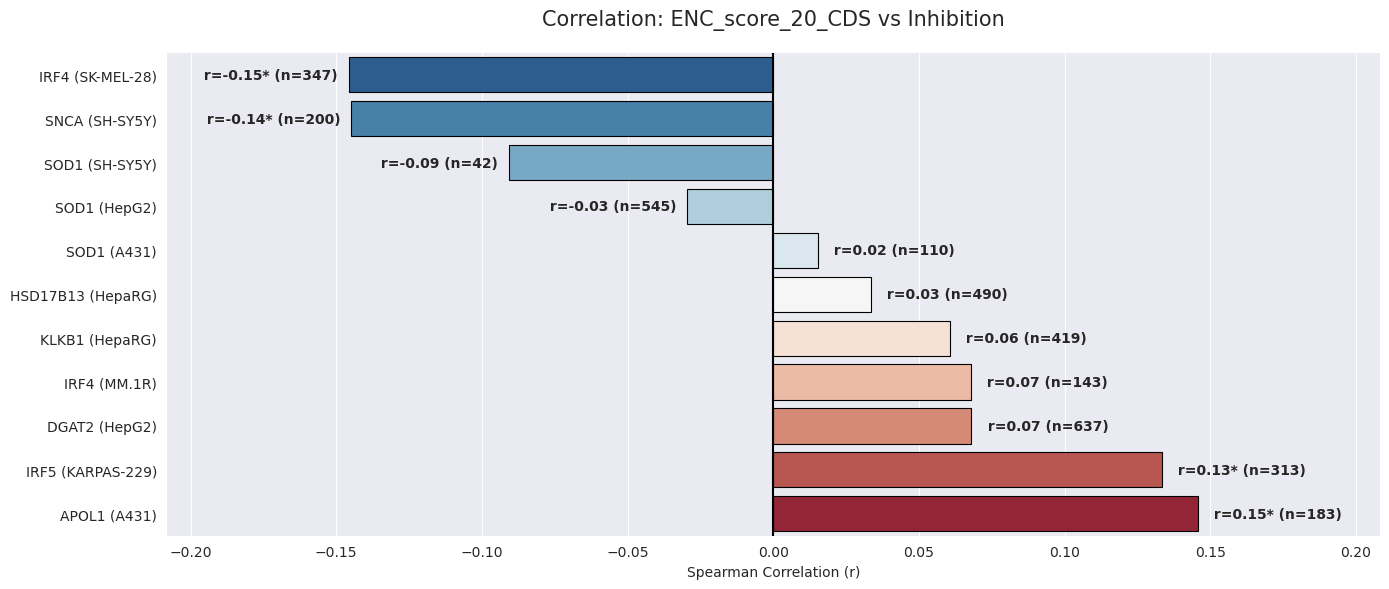

/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


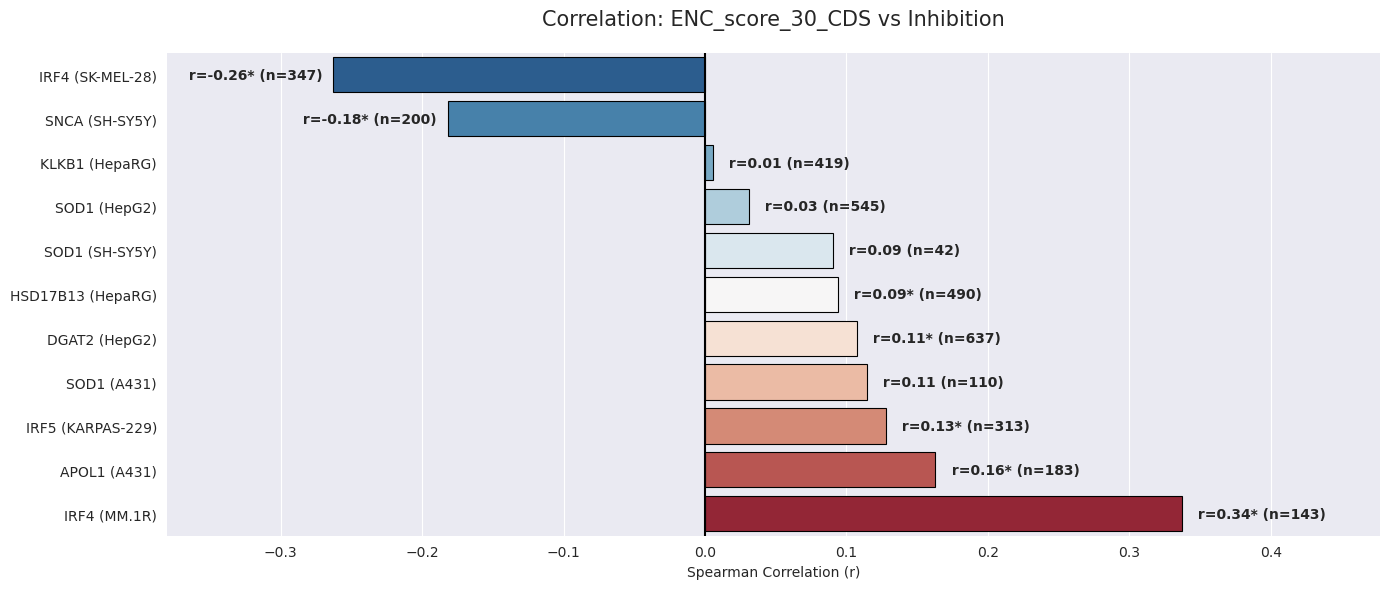

/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


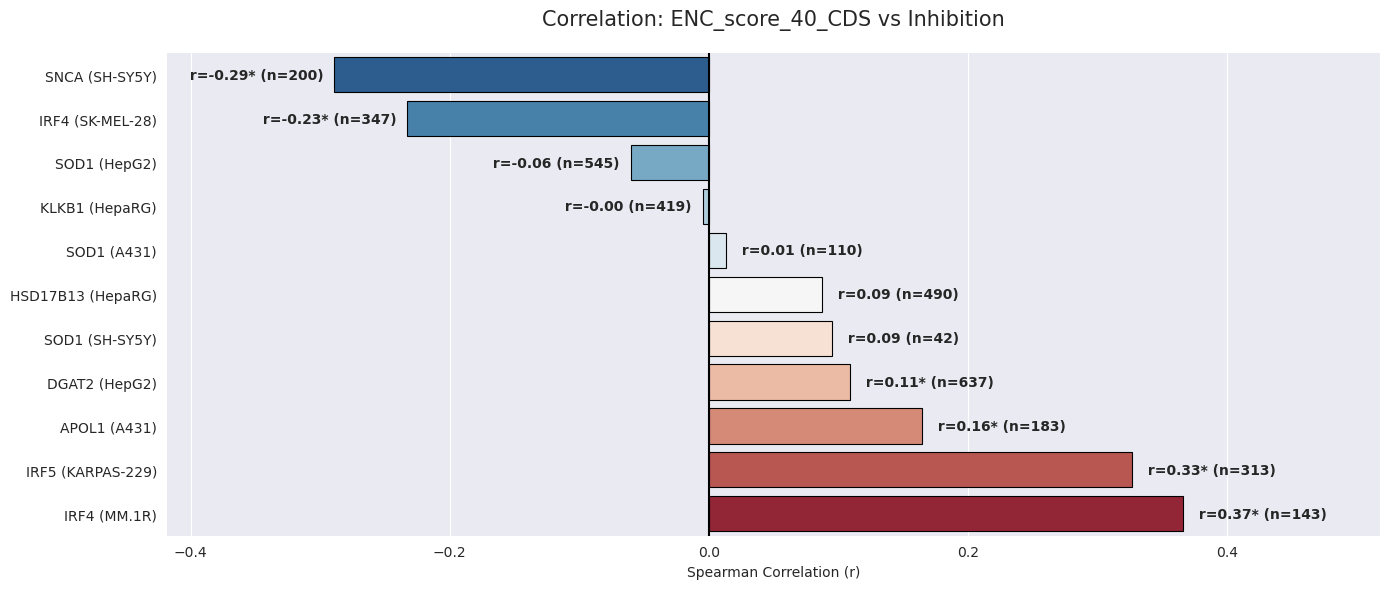

/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


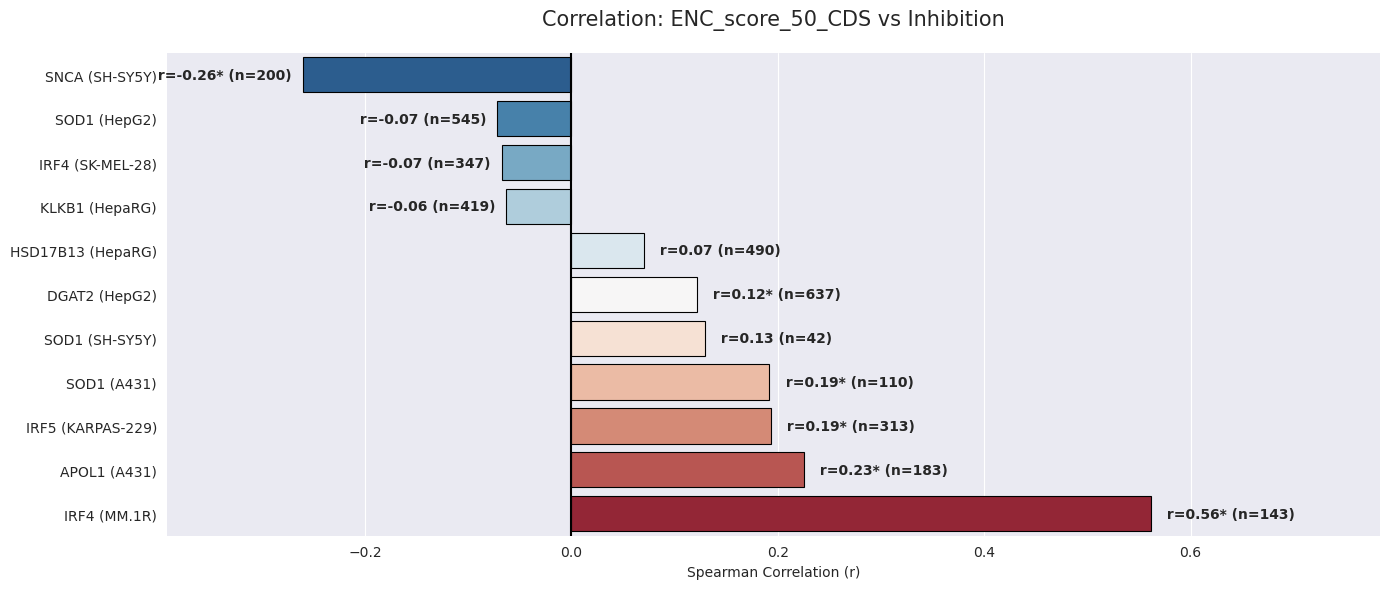

/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


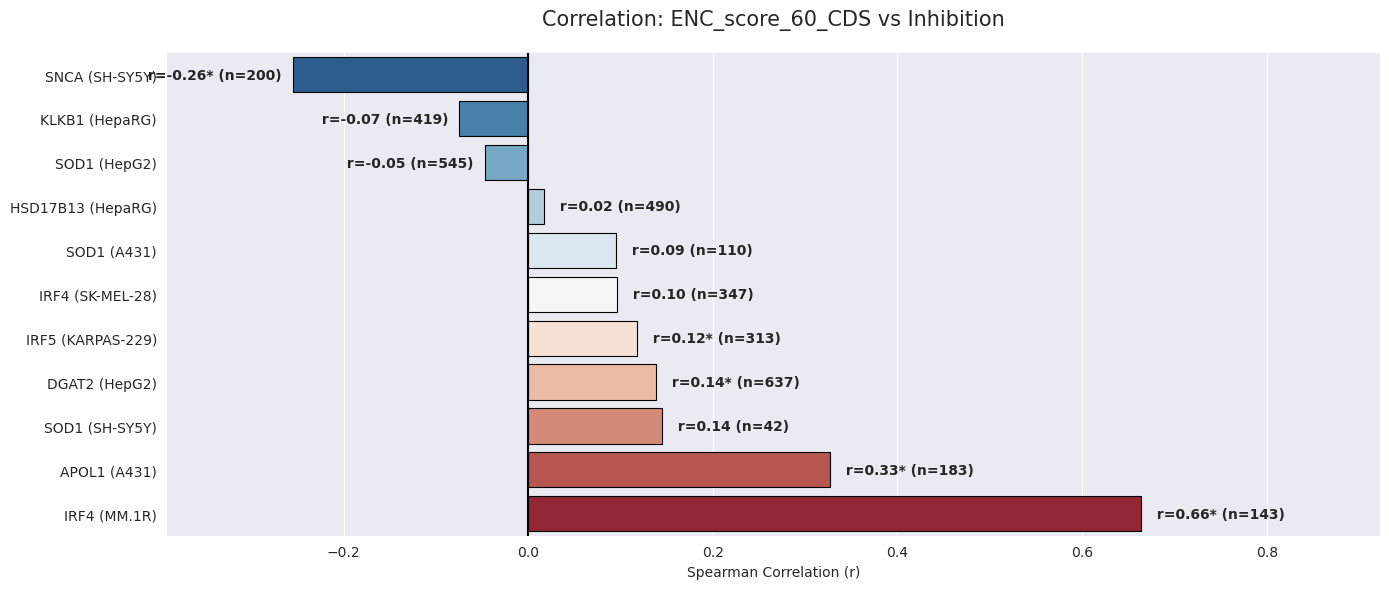

/tmp/ipykernel_533844/3968509927.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


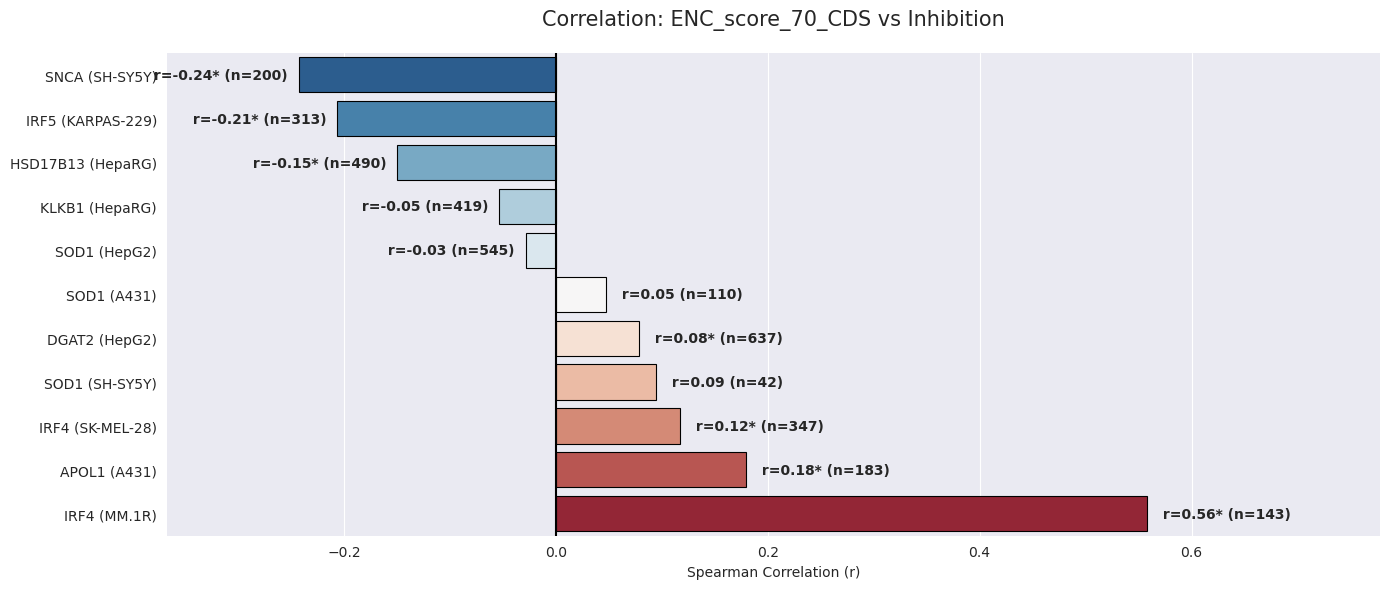

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- STEP 1: GENERATE DATA (PER COHORT ANALYSIS) ---
def analyze_correlations_per_cohort(df, target, features, cohort_cols=['Cell_line', CANONICAL_GENE]):
    results = []
    # Group by Cell Line and Gene
    grouped = df.groupby(cohort_cols)
    print(f"Analyzing {len(grouped)} cohorts...")

    for (cell_line, gene), group in grouped:
        if len(group) < 20: continue # Skip small cohorts

        for feature in features:
            if feature not in group.columns: continue

            # Get valid data for this specific feature + target pair
            valid_data = group[[feature, target]].dropna()

            # Skip if variance is 0 (e.g. Global CAI for a single gene)
            if valid_data[feature].nunique() <= 1: continue

            rho, p_val = spearmanr(valid_data[feature], valid_data[target])

            if pd.notna(rho):
                results.append({
                    'Cell_Line': cell_line,
                    'Gene': gene,
                    'Feature': feature,
                    'Spearman_Rho': rho,
                    'P_Value': p_val,
                    'N_Samples': len(valid_data)
                })

    return pd.DataFrame(results)

# 1. Define Feature List (Dynamic based on what exists)
cai_feature_list = [f for f in df_with_context.columns if "ENC_score_" in f]
print(f"Features to analyze: {cai_feature_list}")

# 2. Run Analysis
print("Running per-cohort analysis...")
cohort_results_df = analyze_correlations_per_cohort(
    df_with_context,
    target='log_inhibition',
    features=cai_feature_list
)

# --- STEP 2: PLOT ALL FEATURES (FOREST PLOT) ---
def plot_correlation_forest(df_results, feature_name):
    MIN_SAMPLES = 20

    # Filter Data for this specific feature
    plot_data = df_results[
        (df_results['Feature'] == feature_name) &
        (df_results['N_Samples'] >= MIN_SAMPLES)
    ].copy()

    if plot_data.empty:
        print(f"Skipping {feature_name}: No cohorts met criteria (n>={MIN_SAMPLES}).")
        return

    # Create Label: "Gene (Cell Line)"
    plot_data['Cohort_Label'] = plot_data['Gene'] + " (" + plot_data['Cell_Line'] + ")"

    # Sort by correlation (Visual Ladder)
    plot_data = plot_data.sort_values('Spearman_Rho', ascending=True)

    # Setup Figure
    plt.figure(figsize=(14, max(6, len(plot_data) * 0.4)))

    # Draw Bar Plot with Explicit Order
    ax = sns.barplot(
        data=plot_data,
        x='Spearman_Rho',
        y='Cohort_Label',
        palette='RdBu_r',
        edgecolor='black',
        linewidth=0.8,
        order=plot_data['Cohort_Label'] # <--- Critical for alignment
    )

    plt.axvline(x=0, color='black', linewidth=1.5, linestyle='-')

    # Expand margins for text
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min * 1.3, x_max * 1.3)

    # Annotate bars
    for i, p in enumerate(ax.patches):
        # Because we used 'order=', patches align 1:1 with sorted dataframe
        row = plot_data.iloc[i]
        val = row['Spearman_Rho']
        count = row['N_Samples']
        p_val = row['P_Value']

        sig_mark = "*" if p_val < 0.05 else ""
        ha = 'right' if val < 0 else 'left'
        offset = -8 if val < 0 else 8

        ax.annotate(
            f" r={val:.2f}{sig_mark} (n={count})",
            (val, p.get_y() + p.get_height()/2),
            va='center', ha=ha,
            fontsize=10, fontweight='bold',
            xytext=(offset, 0),
            textcoords='offset points'
        )

    plt.title(f"Correlation: {feature_name} vs Inhibition", fontsize=15, pad=20)
    plt.xlabel("Spearman Correlation (r)")
    plt.ylabel("")
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# --- STEP 3: EXECUTE LOOP ---
if not cohort_results_df.empty:
    # Get every unique feature that actually produced a result
    unique_features = cohort_results_df['Feature'].unique()
    print(f"Generating plots for {len(unique_features)} features...")

    for feat in unique_features:
        plot_correlation_forest(cohort_results_df, feat)
else:
    print("No correlations found. Check if df_with_context has valid data and genes.")

In [ ]:
from notebooks.utils.correlation_test  import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='ENC', title='ENC Score Correlations with log_inhibition')